# Présentation du projet
> Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.
Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Extraction des données

In [1]:
# Basic librairies
import pandas as pd
import numpy as np
import re 
from bs4 import BeautifulSoup

#NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# Spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Downloading modules
nlp = spacy.load("en_core_web_lg")
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download()

/home/ralph/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
[nltk_data] Downloading package stopwords to /home/ralph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
# Extraction des données
data1 = pd.read_csv("data/data1.csv")
data2 = pd.read_csv("data/data2.csv")
data3 = pd.read_csv("data/data3.csv")
data4 = pd.read_csv("data/data4.csv")
data1.info(), data2.info(), data3.info(), data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      5000 non-null   int64 
 1   Body    5000 non-null   object
 2   Title   3329 non-null   object
 3   Tags    3329 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      5000 non-null   int64 
 1   Body    5000 non-null   object
 2   Title   3329 non-null   object
 3   Tags    3329 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      5000 non-null   int64 
 1   Body    5000 non-null   object
 2

(None, None, None, None)

In [3]:
# Création du dataframe final via des jointures
d1 = pd.concat([data1, data2], ignore_index = True)
d2 = pd.concat([data3, data4], ignore_index = True)
query = pd.concat([d1, d2], ignore_index = True)

In [4]:
# Suppression des lignes dupliquées ou vides
query.dropna(inplace = True)
query.drop_duplicates(subset = ["Id"], inplace = True)
query = query.reset_index(drop = True)
query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      8319 non-null   int64 
 1   Body    8319 non-null   object
 2   Title   8319 non-null   object
 3   Tags    8319 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.1+ KB


In [5]:
# On vas sampler le dataframe pour n'en utiliser que 1000 observations au  vue de la vitesse de mon processeur
query = query.sample(n=1000,replace=True)
query = query.reset_index(drop = True)

## Traitement de la colonne Tags

In [6]:
# Présentation de la colonne "Tags"
query["Tags"]

0                         <c#><unity3d><text><scripting>
1                      <android-emulator><macos-big-sur>
2          <python><web-scraping><beautifulsoup><urllib>
3                                    <c#><json><mapping>
4                      <android-emulator><macos-big-sur>
                             ...                        
995                          <automation><gitlab-ci><qa>
996       <javascript><ajax><google-chrome><file-upload>
997                  <python><python-3.x><linux><ubuntu>
998    <jquery><json><ajax><fullcalendar><fullcalenda...
999                    <c++><memory><fstream><libstdc++>
Name: Tags, Length: 1000, dtype: object

In [7]:
# Extraction des mots-clés sans les hashtags(#)
for i in range(len(query)):
    query["Tags"][i] = re.sub("><", ",", query["Tags"][i])
    query["Tags"][i] = re.sub(r">|<", "", query["Tags"][i])
    query["Tags"][i] = query["Tags"][i].split(",")
query["Tags"]

0                         [c#, unity3d, text, scripting]
1                      [android-emulator, macos-big-sur]
2          [python, web-scraping, beautifulsoup, urllib]
3                                    [c#, json, mapping]
4                      [android-emulator, macos-big-sur]
                             ...                        
995                          [automation, gitlab-ci, qa]
996       [javascript, ajax, google-chrome, file-upload]
997                  [python, python-3.x, linux, ubuntu]
998    [jquery, json, ajax, fullcalendar, fullcalenda...
999                    [c++, memory, fstream, libstdc++]
Name: Tags, Length: 1000, dtype: object

In [8]:
# Traitement de la variable "Tags"
all_tags = [item for sublist in query['Tags'].values for item in sublist]
unique_tags = set(all_tags)
freq_distribution = nltk.FreqDist(all_tags)
freq_tag = freq_distribution.most_common(100)
popular_tag = [tag[0] for tag in freq_tag]

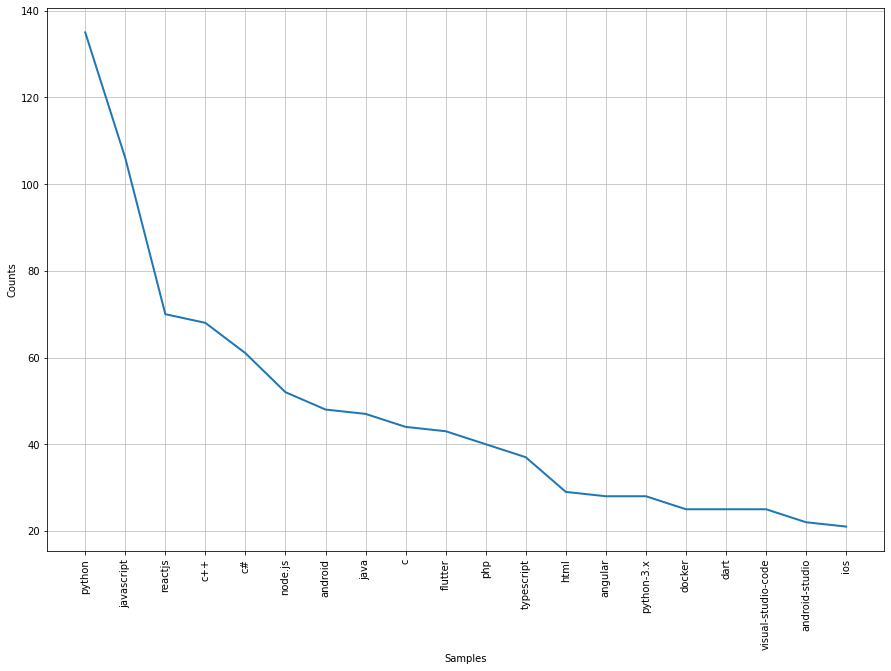

In [9]:
# Graphique présentant le Top 20 des tags les plus utilisés
fig, ax = plt.subplots(figsize=(15, 10))
freq_distribution.plot(20, cumulative=False)
plt.show()

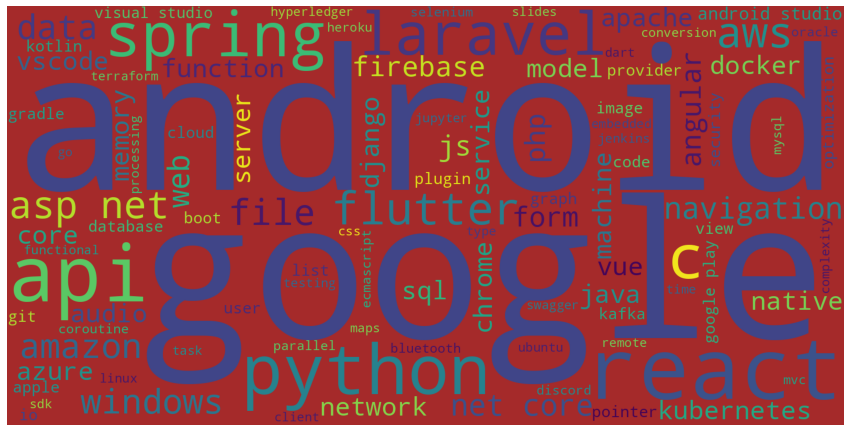

In [10]:
# Présentation des tags présents sur les posts via un wordCloud
txt_tags = " ".join(unique_tags) # Ensemble de tous les tags sans les virgules de sorte à former un texte
fig = plt.figure(figsize=(15,10))
wordcloud = WordCloud(background_color = 'brown',width=1600, height=800, max_words = 100).generate(txt_tags)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in popular_tag:
            tags_filtered.append(tags[i])
    return tags_filtered

In [12]:
query['Tags'] = query['Tags'].apply(lambda x: most_common(x))
query['Tags'] =query['Tags'].apply(lambda x: x if len(x)>0 else None)
query.dropna(inplace = True)
query = query.reset_index(drop = True)
query

,Id,Body,Title,Tags
0,65961290,<p>I have a TextObject in my script which is a...,Why do i get an Error when trying to change th...,[c#]
1,63576252,<p>I have upgraded the mac OS to Big Sur and n...,Android emulators are not working on macOS Big...,[android-emulator]
2,64521219,<p>I am trying to get a JSON response from the...,I get InvalidURL: URL can't contain control ch...,"[python, beautifulsoup]"
3,67740516,<p>I need some help to map a json array withou...,Mapping a json array (without keys) to a class...,"[c#, json]"
4,63576252,<p>I have upgraded the mac OS to Big Sur and n...,Android emulators are not working on macOS Big...,[android-emulator]
...,...,...,...,...
888,59936041,<p>I've made a program which reads numbers fro...,Weird dumpcore error while executing my progra...,"[c, list]"
889,61916331,<p>I have a simple HTML form that sends an sel...,Re-uploading a file with AJAX after it was cha...,"[javascript, ajax, google-chrome]"
890,61076632,<p>I made a mess out of my self. \nI wanted to...,Errors were encountered while processing:,"[python, python-3.x, linux, ubuntu]"
891,65195807,<p>I'm trying to make dynamic calendarevents. ...,Fullcalender json feeds,"[jquery, json, ajax]"


## Traitement de la colonne body

In [13]:
# Présentation de la colonne "Body"
query["Body"]

0      <p>I have a TextObject in my script which is a...
1      <p>I have upgraded the mac OS to Big Sur and n...
2      <p>I am trying to get a JSON response from the...
3      <p>I need some help to map a json array withou...
4      <p>I have upgraded the mac OS to Big Sur and n...
                             ...                        
888    <p>I've made a program which reads numbers fro...
889    <p>I have a simple HTML form that sends an sel...
890    <p>I made a mess out of my self. \nI wanted to...
891    <p>I'm trying to make dynamic calendarevents. ...
892    <p>I need to read a series of numbers from <a ...
Name: Body, Length: 893, dtype: object

In [14]:
# Extraction du texte présent dans les balises

for i in range(len(query)):
    soup = BeautifulSoup(query.iloc[i, 1], 'lxml')    
    query.iloc[i, 1] = soup.get_text()
query.head(3)

,Id,Body,Title,Tags
0,65961290,I have a TextObject in my script which is atta...,Why do i get an Error when trying to change th...,[c#]
1,63576252,I have upgraded the mac OS to Big Sur and none...,Android emulators are not working on macOS Big...,[android-emulator]
2,64521219,I am trying to get a JSON response from the li...,I get InvalidURL: URL can't contain control ch...,"[python, beautifulsoup]"


## Concaténation des colonnes Body et Title

In [15]:
# jointure entre les variables "Title" et "Body"
query["Text"] = query["Title"] + " " + query["Body"]
query.drop(columns = ["Body", "Title", "Id"], inplace = True)
query.head()

,Tags,Text
0,[c#],Why do i get an Error when trying to change th...
1,[android-emulator],Android emulators are not working on macOS Big...
2,"[python, beautifulsoup]",I get InvalidURL: URL can't contain control ch...
3,"[c#, json]",Mapping a json array (without keys) to a class...
4,[android-emulator],Android emulators are not working on macOS Big...


In [16]:
df = query["Text"]

# Conversion en liste
data = df.values.tolist()

# suppression des caractères inutiles
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

In [17]:
# tokenization des phrases
data_words = data.copy()
for i in range(len(data)):
    tokenizer = RegexpTokenizer(r'\w+')
    data_words[i] = tokenizer.tokenize(data[i])

In [18]:
# Construction du modèle de bigramme
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [19]:
# Suppression des stopwords, mise en place des bigrammes et lemmatization

# Definition des fonctions pour les différentes opérations
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Suppression des stopwords
data_words_nostops = remove_stopwords(data_words)

# Formation des bigrammes
data_words_bigrams = make_bigrams(data_words_nostops)

# Lemmatisation avec conservation des noms, noms propres et adjectifs
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ','PROPN'])

In [21]:
# Creation du dictionnaire des mots
dict = corpora.Dictionary(data_lemmatized)

# Creation du corpus via la détermination de la fréquence des mots dans le document
texts = data_lemmatized
corpus = [dict.doc2bow(text) for text in texts]

In [22]:
# Mise en place du modèle LDA
lda_model =LdaMulticore(corpus,
                        id2word=dict, 
                        num_topics=20)

In [23]:
# Détermination du score de cohérence
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda, lda_model.log_perplexity(corpus)

(0.3568307764794961, -8.315381246802108)

In [24]:
# Optimisation des hyperparamètres "chunksize" et "passes" afin d'avoir un meilleur coefficient de cohérence

# Optimisation de l'hyperparamètre "chunksize"
df_chunksize = pd.DataFrame(columns = ["Chunksize", "Coherence"])
j =  0
for i in range(5,200,5):
    lda_ = LdaMulticore(corpus,
                        id2word=dict, 
                        num_topics=20,
                       chunksize = i)
    coherence_model_lda = CoherenceModel(model=lda_,
                                         texts=data_lemmatized, 
                                         dictionary=dict, 
                                         coherence='c_v')
    c = coherence_model_lda.get_coherence()
    
    df_chunksize.loc[j,"Chunksize"] = i
    df_chunksize.loc[j,"Coherence"] = c
    j = j+1

In [25]:
# Valeur de chunksize optimale
df_chunksize.sort_values(by = 'Coherence', ascending = False).head(1)

,Chunksize,Coherence
22,115,0.376917


In [26]:
# Optimisation l'hyperparamètre "passes"
df_passes = pd.DataFrame(columns = ["Passes", "Coherence"])
j =  0
for i in range(1,100,1):
    lda_ = LdaMulticore(corpus,
                        id2word=dict, 
                        num_topics=20,
                        chunksize = 115,
                        passes = i)
    coherence_model_lda = CoherenceModel(model=lda_,
                                         texts=data_lemmatized, 
                                         dictionary=dict, 
                                         coherence='c_v')
    c = coherence_model_lda.get_coherence()
    
    df_passes.loc[j,"Passes"] = i
    df_passes.loc[j,"Coherence"] = c
    j = j + 1

In [27]:
# Valeur de "passes" optimale
df_passes.sort_values(by = 'Coherence', ascending = False).head(1)

,Passes,Coherence
69,70,0.476451


In [28]:
# modèle LDA final sur les hyperparamètres adjustés
lda_model = LdaMulticore(corpus,
                        id2word=dict, 
                        num_topics=20,
                        chunksize = 115,
                        passes = 70
                        )

In [29]:
pyLDAvis.enable_notebook()
panel = gensimvis.prepare(lda_model, corpus, dict, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      -10.878068   10.538728       1        1  13.765924
3      -60.884026  -75.591820       2        1  10.041346
17      -2.336119  -53.289074       3        1   7.507441
11     -61.385319  -12.914634       4        1   6.939907
2      -28.737743  126.296997       5        1   6.852452
6        1.066606 -123.552811       6        1   6.759732
10      45.140720   -7.947869       7        1   5.902565
15    -140.795975  -98.530548       8        1   5.152417
16      61.531681  -83.240562       9        1   4.490707
0      -72.563057 -140.396881      10        1   4.481935
7       15.984491   63.578186      11        1   4.108391
9     -160.851624   68.945145      12        1   3.593831
5       85.961830   51.922935      13        1   3.303887
18     -99.020836  109.936348      14        1   2.959388
4     -176.764130   -8.681684      15        1   2.923169
19    -117.189880  -37.420200      16        1   2.584770
14     108.829918  -22.946203      17        1   2.433882
12      47.588097  121.934814      18        1   2.398237
8     -106.467834   30.176889      19        1   2.148636
13     -50.613804   59.328842      20        1   1.651383, topic_info=         Term        Freq        Total Category  logprob  loglift
531      java  785.000000   785.000000  Default  30.0000  30.0000
58    android  662.000000   662.000000  Default  29.0000  29.0000
16        int  815.000000   815.000000  Default  28.0000  28.0000
482        js  565.000000   565.000000  Default  27.0000  27.0000
1175     dart  323.000000   323.000000  Default  26.0000  26.0000
...       ...         ...          ...      ...      ...      ...
115    server   15.534471   388.254274  Topic20  -4.8313   0.8850
2771      msg   11.383703    47.529446  Topic20  -5.1422   2.6744
11      error   13.331934  1388.560802  Topic20  -4.9842  -0.5423
167       var   11.820097   370.361169  Topic20  -5.1045   0.6589
273      code   12.056875   838.087214  Topic20  -5.0847  -0.1379

[1264 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
55        2  0.604594        _
55        3  0.070536        _
55        6  0.151148        _
55       10  0.050383        _
55       13  0.070536        _
...     ...       ...      ...
1565      2  0.899183     year
1565     17  0.079927     year
3987     10  0.839536  youtube
5506     12  0.975321     yyyy
2581      4  0.955352       za

[3023 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 18, 12, 3, 7, 11, 16, 17, 1, 8, 10, 6, 19, 5, 20, 15, 13, 9, 14])

In [30]:
pyLDAvis.save_html(panel, 'lda.html')

In [31]:
lda_model.print_topics(num_words=5)

[(0,
  '0.051*"class" + 0.031*"self" + 0.024*"public" + 0.016*"item" + 0.015*"setting"'),
 (1,
  '0.024*"error" + 0.023*"user" + 0.022*"const" + 0.016*"json" + 0.015*"datum"'),
 (2,
  '0.076*"android" + 0.027*"app" + 0.021*"version" + 0.018*"dev" + 0.016*"com"'),
 (3,
  '0.031*"file" + 0.018*"line" + 0.016*"loop" + 0.015*"code" + 0.015*"row"'),
 (4,
  '0.052*"apache" + 0.030*"libexec" + 0.027*"loadmodule" + 0.019*"directory" + 0.017*"file"'),
 (5,
  '0.044*"color" + 0.038*"temp" + 0.030*"break_case" + 0.025*"icon" + 0.023*"widget"'),
 (6,
  '0.023*"jar" + 0.020*"org_springframework" + 0.019*"java" + 0.016*"python" + 0.015*"user"'),
 (7,
  '0.065*"dart" + 0.027*"flutter" + 0.019*"datum" + 0.017*"context" + 0.016*"value"'),
 (8,
  '0.068*"old" + 0.035*"uint" + 0.029*"rgbtgreen" + 0.029*"rgbtblue" + 0.027*"model"'),
 (9, '0.070*"js" + 0.066*"npm" + 0.039*"node" + 0.028*"error" + 0.016*"err"'),
 (10, '0.030*"class" + 0.027*"html" + 0.026*"text" + 0.025*"div" + 0.025*"i"'),
 (11,
  '0.029*"

In [32]:
query["Text"] = data_lemmatized

In [33]:
# Transformons la colonne "Text" en chaîne de caractère afin de permettre des traitements utérieures
df = query.copy()
for i in range(len(df)):
    df.loc[i, "Text"] = " ".join(query.loc[i, "Text"])
df

,Tags,Text
0,[c#],error text textobject textobject script canvas...
1,[android-emulator],android macos big sur mac big sur none working...
2,"[python, beautifulsoup]",invalidurl url control character request urlli...
3,"[c#, json]",json array key class object help json array ke...
4,[android-emulator],android macos big sur mac big sur none working...
...,...,...
888,"[c, list]",weird dumpcore error program program number ma...
889,"[javascript, ajax, google-chrome]",file ajax net chrome simple html form file aja...
890,"[python, python-3.x, linux, ubuntu]",error processing mess self python system unins...
891,"[jquery, json, ajax]",fullcalender json feed dynamic calendarevent c...


In [34]:
# Sauvegarde du fichier traité
df.to_csv("clean_dataset.csv", index = False, sep = ',')